# UMAPs Neurips samples, NK cells

In this notebook UMAPs are generated from latent space, CLR transformed protein counts and RNA expression to compare the clustering results. Leiden clusters are calculated for each object (latent, protein and RNA) and highly expressed genes/markers are searched using scanpy rank_genes_groups -function. 

Markers are collected from: 

Melsen, J. E., van Ostaijen-Ten Dam, M. M., Schoorl, D. J. A., Schol, P. J., van den Homberg, D. A. L., Lankester, A. C., Lugthart, G., & Schilham, M. W. (2022). Single-cell transcriptomics in bone marrow delineates CD56dimGranzymeK+ subset as intermediate stage in NK cell differentiation. Frontiers in immunology, 13, 1044398. https://doi.org/10.3389/fimmu.2022.1044398

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import scvi
import scanpy as sc
import umap

from ridgeplot import ridgeplot
from pySankey import sankey

import warnings

warnings.filterwarnings('ignore')



# 1. Preparations

In [30]:
#Neurips

adata = sc.read_h5ad('/Users/tiinatuononen/Desktop/Thesis/Project/data/adata_neurips_norm_outer.h5ad')

In [31]:
import scipy.sparse

#loading in connectivities matrix (calculated from RNA expression) 

connect = scipy.sparse.load_npz('/Users/tiinatuononen/Desktop/Thesis/Project/data/connectivities (1).npz')

connect

<80998x80998 sparse matrix of type '<class 'numpy.float32'>'
	with 2261244 stored elements in Compressed Sparse Row format>

In [32]:
#addint connectivities matrix to obsm 

adata.obsp['connectivities'] = connect

adata

AnnData object with n_obs × n_vars = 80998 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_totalVI', 'X_umap', 'protein_expression', 'protein_expression_clr_neurips'
    layers: 'counts'
    obsp: 'connectivities'

In [33]:
#loading in distance matrix (calculated from RNA expression)

dist = scipy.sparse.load_npz('/Users/tiinatuononen/Desktop/Thesis/Project/data/distances (1).npz')

dist

<80998x80998 sparse matrix of type '<class 'numpy.float64'>'
	with 1133972 stored elements in Compressed Sparse Row format>

In [34]:
adata.obsp['distances'] = dist

adata

AnnData object with n_obs × n_vars = 80998 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_totalVI', 'X_umap', 'protein_expression', 'protein_expression_clr_neurips'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [35]:
#saved neigbors

import pickle

with open('saved_dictionary.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

loaded_dict

{'connectivities_key': 'connectivities',
 'distances_key': 'distances',
 'params': {'n_neighbors': 15,
  'method': 'umap',
  'random_state': 0,
  'metric': 'euclidean',
  'use_rep': 'adata_x'}}

In [36]:
#adding neigbors to uns layer

adata.uns['neighbors'] = loaded_dict

adata

AnnData object with n_obs × n_vars = 80998 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS'
    uns: 'neighbors'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_totalVI', 'X_umap', 'protein_expression', 'protein_expression_clr_neurips'
    layers: 'counts'
    obsp: 'connectivities', '

In [37]:
#Selecting only one sample
adata =adata[adata.obs['POOL'] == "s2d1"]

In [38]:
adata

View of AnnData object with n_obs × n_vars = 9684 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS'
    uns: 'neighbors'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_totalVI', 'X_umap', 'protein_expression', 'protein_expression_clr_neurips'
    layers: 'counts'
    obsp: 'connectivit

In [39]:
#protein information

adata_prot=adata.obsm['protein_expression_clr_neurips']

In [40]:
#some proteins and genes have same names, here _prot added after protein names

adata_prot=adata_prot.rename(columns={'CD2': 'CD2_prot', 'CX3CR1': 'CX3CR1_prot', 'CD226':'CD226_prot', 'TIGIT':'TIGIT_prot', 'CD27':'CD27_prot', 'CD38': 'CD38_prot','CD34': 'CD34_prot', 'CD224': 'CD224_prot', 'CD7': 'CD7_prot', 'CD44': 'CD44_prot', 'CD34': 'CD34_prot','CD5': 'CD5_prot'})

In [41]:
#adding protein information to obs

a = adata.obs
b = adata_prot

df=pd.concat([a, b], axis=1)
adata.obs=df

In [42]:
adata

AnnData object with n_obs × n_vars = 9684 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS', 'CD86', 'CD274', 'CD270', 'CD155', 'CD112', 'CD47', 'CD48', 'CD40', 'CD154', 'CD52', 'CD3', 'CD8', 'CD56', 'CD19', 'CD33', 'CD11c', 'HLA-A-B-C', 'CD45RA', 'CD123', 'CD7_prot', 'CD105', 'CD49f', 'CD194', 'CD4', 'CD44_prot', 'CD14', 'CD16', 'CD25',

Here 3. different objects from the same adata object are created; latent, protein and RNA. UMAP neigbors are calculated differently for each object (either using latent space, CLR normalized protein, or RNA expression data and then visualized using UMAP projection. 

In [43]:
#Neurips, latent

adata_neurips_latent = adata.copy()

In [44]:
#Neurips, proteins

adata_neurips_prot = adata.copy()

In [45]:
#Neurips, RNA

adata_neurips_rna = adata.copy()

In [46]:
#RNA data is added to obs 

adata_neurips_rna.obsm['adata_x'] = adata_neurips_rna.to_df()

In [47]:
adata_neurips_rna

AnnData object with n_obs × n_vars = 9684 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS', 'CD86', 'CD274', 'CD270', 'CD155', 'CD112', 'CD47', 'CD48', 'CD40', 'CD154', 'CD52', 'CD3', 'CD8', 'CD56', 'CD19', 'CD33', 'CD11c', 'HLA-A-B-C', 'CD45RA', 'CD123', 'CD7_prot', 'CD105', 'CD49f', 'CD194', 'CD4', 'CD44_prot', 'CD14', 'CD16', 'CD25',

In [48]:
#Both NK cell types selected + one sample is selected

sample_latent = adata_neurips_latent[(adata_neurips_latent.obs['cell_type'] == "NK") | (adata_neurips_latent.obs['cell_type'] == "NK CD158e1+")]

In [49]:
#Both NK cell types selected  + one sample is selected

sample_prot = adata_neurips_prot[(adata_neurips_prot.obs['cell_type'] == "NK") | (adata_neurips_prot.obs['cell_type'] == "NK CD158e1+")]

In [50]:
#Both NK cell types selected  + one sample is selected

sample_rna = adata_neurips_rna[(adata_neurips_rna.obs['cell_type'] == "NK") | (adata_neurips_rna.obs['cell_type'] == "NK CD158e1+")]

In [51]:
#Calculating neighbors for UMAPs

sc.pp.neighbors(sample_latent, use_rep="X_totalVI")   
sc.pp.neighbors(sample_prot, use_rep="protein_expression_clr_neurips") 
sc.pp.neighbors(sample_rna, use_rep="adata_x") 


sc.tl.umap(sample_latent)
sc.tl.umap(sample_prot)
sc.tl.umap(sample_rna)

## Leiden clusters

In [52]:
#Calculating leidens for latent object
sc.tl.leiden(sample_latent, resolution = 0.2, key_added = "leiden_0.2")
sc.tl.leiden(sample_latent, resolution = 0.4, key_added = "leiden_0.4")
sc.tl.leiden(sample_latent, resolution = 0.6, key_added = "leiden_0.6")

#calculating leidens for protein object

sc.tl.leiden(sample_prot, resolution = 0.2, key_added = "leiden_0.2")
sc.tl.leiden(sample_prot, resolution = 0.4, key_added = "leiden_0.4")
sc.tl.leiden(sample_prot, resolution = 0.6, key_added = "leiden_0.6")

#calculating leidens for RNA object
sc.tl.leiden(sample_rna, resolution = 0.8, key_added = "leiden_0.8")
sc.tl.leiden(sample_rna, resolution = 1.0, key_added = "leiden_1.0")
sc.tl.leiden(sample_rna, resolution = 1.2, key_added = "leiden_1.2")


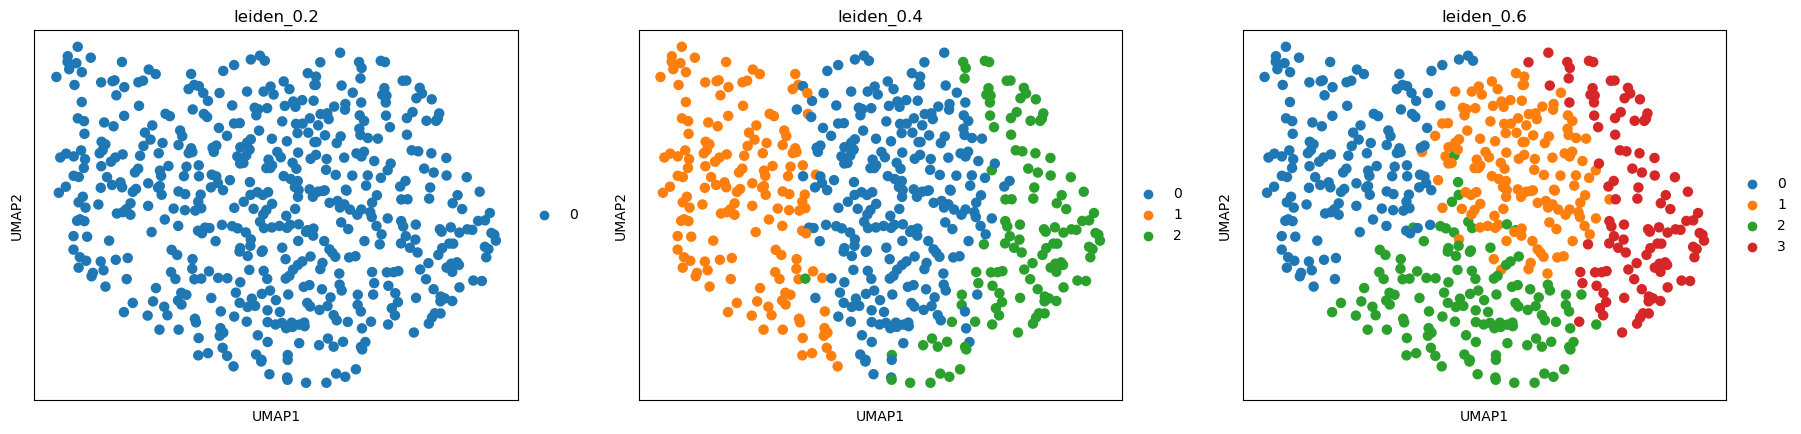

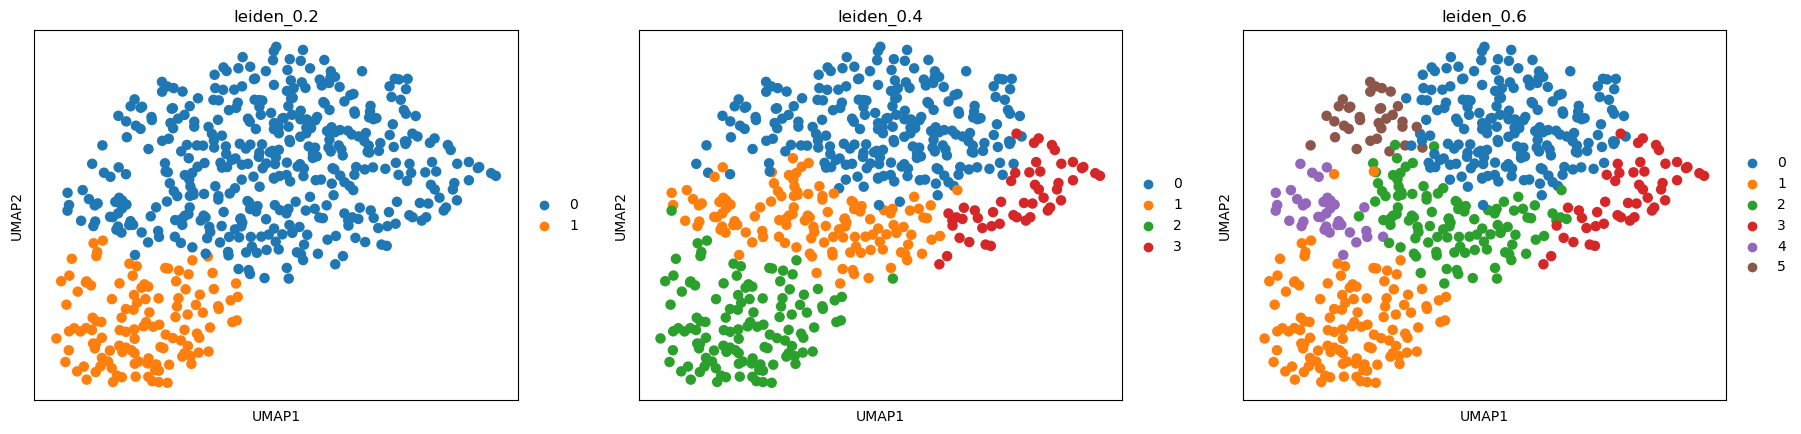

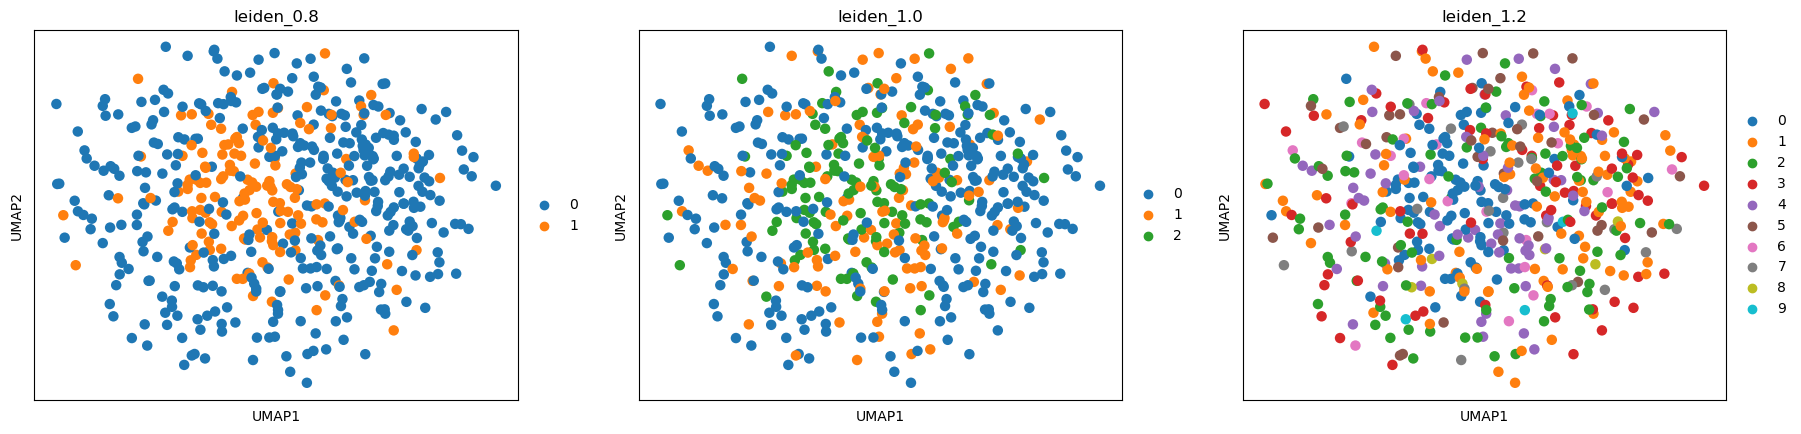

In [53]:
#Showing results in UMAPs


sc.pl.umap(sample_latent, color=['leiden_0.2', 'leiden_0.4', 'leiden_0.6'], ncols =3)
sc.pl.umap(sample_prot, color=['leiden_0.2', 'leiden_0.4', 'leiden_0.6'], ncols =3)
sc.pl.umap(sample_rna, color=['leiden_0.8', 'leiden_1.0', 'leiden_1.2'], ncols =3)

# Find marker genes from leiden clusters

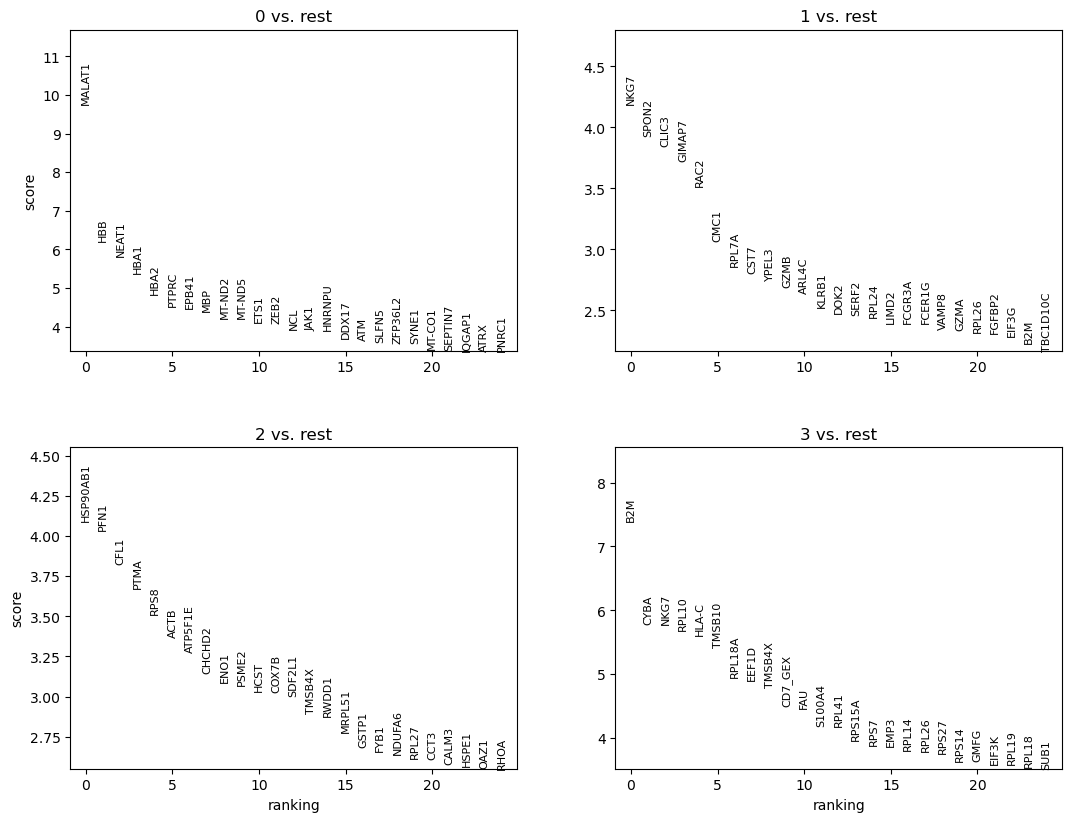

In [58]:
#Latent

sc.tl.rank_genes_groups(sample_latent, 'leiden_0.6', method='wilcoxon')
sc.pl.rank_genes_groups(sample_latent, n_genes=25, sharey=False, ncols=2)

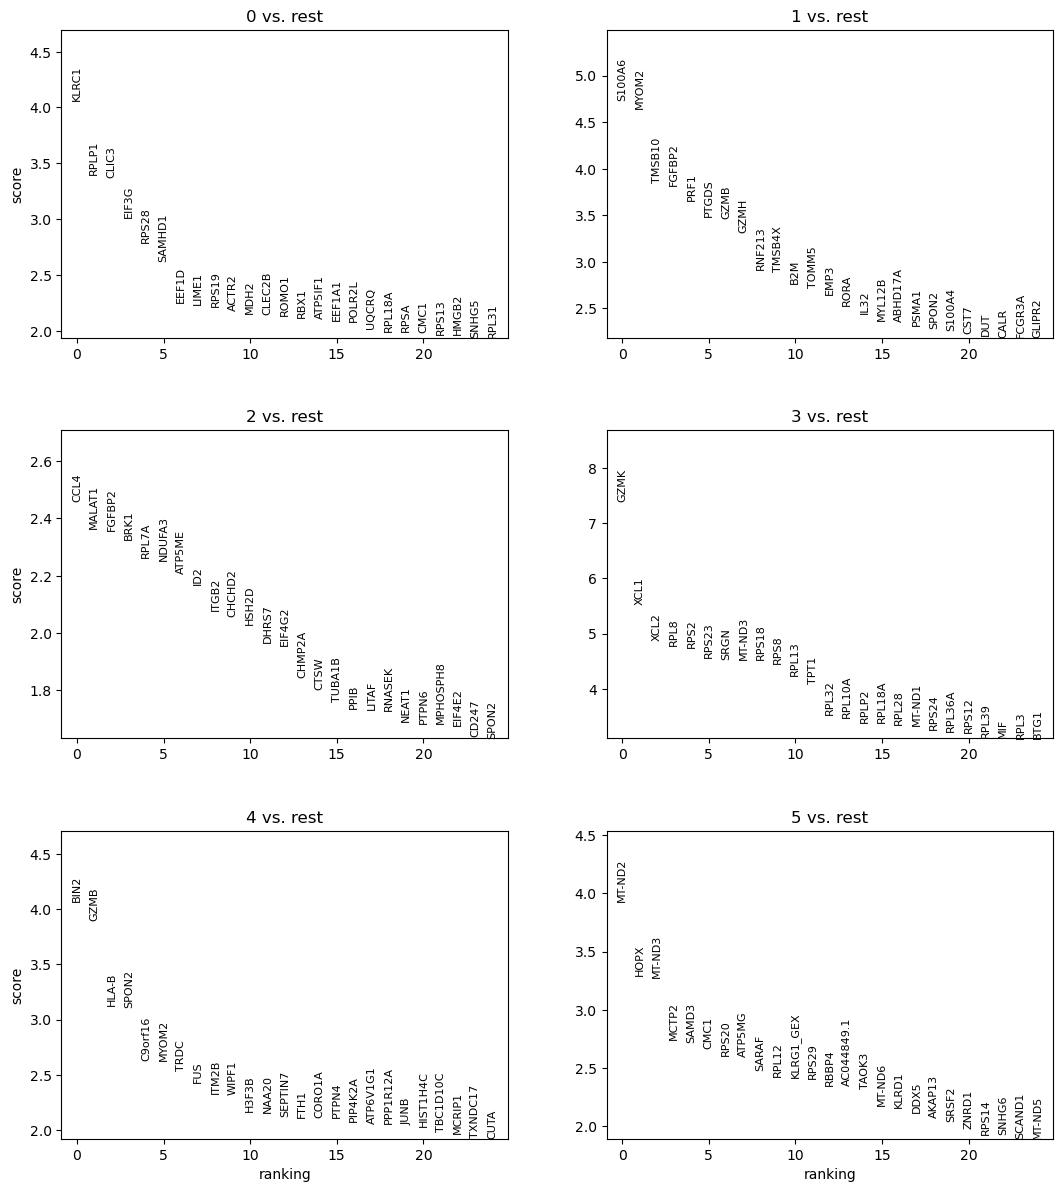

In [57]:
#Protein

sc.tl.rank_genes_groups(sample_prot, 'leiden_0.6', method='wilcoxon')
sc.pl.rank_genes_groups(sample_prot, n_genes=25, sharey=False, ncols=2)

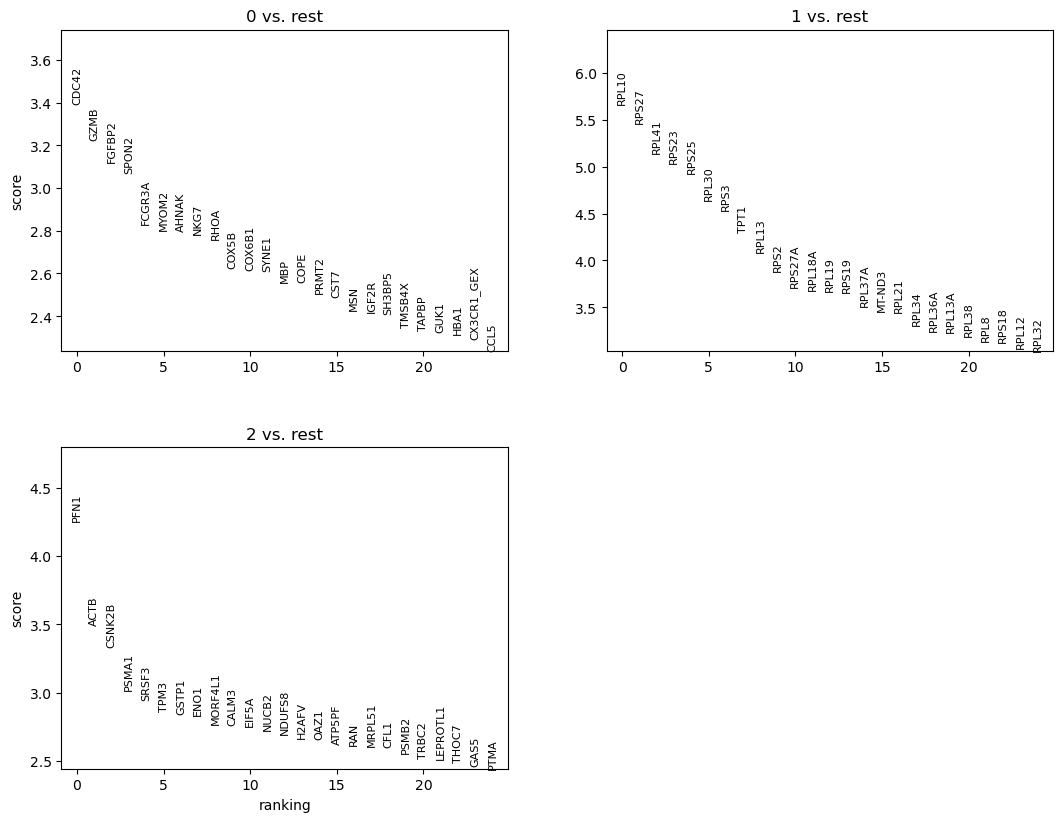

In [56]:
#Protein

sc.tl.rank_genes_groups(sample_rna, 'leiden_1.0', method='wilcoxon')
sc.pl.rank_genes_groups(sample_rna, n_genes=25, sharey=False, ncols=2)